In [1]:
import pandas as pd # for working with dataframes
from os import listdir, makedirs # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns# ; sns.set(color_codes=True) # for plotting in seaborn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from sklearn.model_selection import StratifiedKFold # for Stratified K fold sampling
from sklearn.cluster import AgglomerativeClustering # for agglomerative clustering
import scipy.stats as stats # for kruskal wallis test
import statsmodels.stats.multitest as multitest # multiple test adjustment
from numpy.linalg import det # for sampling higher dimensional convex hull
from scipy.stats import dirichlet
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay
import math
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import trimesh

# Check tracing

In [2]:
# create a list of directories of leaf trace files
dir_list = ["./leaves/", # leaves from Dan
           "./mariana_leaves_08_may/" # leaves from Mariana 08 May 2025
           ]

page_numbers = [] # get the page of the illustration
plant_numbers = [] # get the individual plant
page_plant_IDs = [] # get page_plant_IDs
author_ID = [] # get names of leaf tracers
all_file_names = [] # a list of all file names (not just one folder)
all_directories = [] # a list of directories for each file name

for i in range(len(dir_list)): # for each directory of leaf shapes
    
    data_dir = dir_list[i] # set data directory

    file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names
    
    if '.DS_Store' in file_names:
        file_names.remove('.DS_Store') # remove .DS_Store file

    file_names.sort() # sort the list of file names
    #file_names # check list of file names
    
    # get the page of the illustration
    for j in range(len(file_names)):
        page_numbers.append(file_names[j][:file_names[j].index("_")])

        if i == 0:
            author_ID.append("Dan")
        elif i == 1:
            author_ID.append("Mariana")

        all_file_names.append(file_names[j]) # store all file names
        all_directories.append(data_dir) # store all directory names
    
    # get the individual plant
    for k in range(len(file_names)):
        plant_numbers.append(file_names[k][file_names[k].index("_")+1:file_names[k].rfind("_")])
    
    # get page_plant_IDs
    for l in range(len(file_names)):
        page_plant_IDs.append(file_names[l][:file_names[l].rfind("_")])
    
    

In [3]:
lo = "k" # leaf outline color
w = 0.5 # outline width
alfa = 1 # alpha

pic_dir = "./all_pics/" # set the directory of the pictures
save_dir = "./check/" # set the directory where to save image checks

unique_page_nums = list(set(page_numbers)) # get unique page numbers

for j in range(len(unique_page_nums)): # for each page
    print(j)

    curr_page = unique_page_nums[j] # get current page
    
    curr_image = pic_dir + curr_page + ".png" # get the current image to plot on
    
    plt.figure(figsize=(8.5,11)) # set figure size
    
    img = mpimg.imread(curr_image) # read in current image
    plt.imshow(img)
    
    for i in range(len(file_names)): # plot each leaf
        if curr_page in file_names[i]:
            lf = np.loadtxt(data_dir + file_names[i])
            plt.plot(lf[:,0], lf[:,1], c="k", lw=w)
            plt.fill(lf[:,0], lf[:,1], alpha=alfa)

    plt.savefig(save_dir+curr_page+".png") # save plot
    plt.close()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


# Procrustes Analysis

In [4]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean

# From: https://stackoverflow.com/questions/59073952/how-to-get-uniformly-distributed-points-in-convex-hull
# Accessed 11 February 2024

def dist_in_hull(points, n):
    dims = points.shape[-1]
    hull = points[ConvexHull(points).vertices]
    deln = hull[Delaunay(hull).simplices]

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / math.factorial(dims)    
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

def is_self_intersecting(polygon_coordinates):
    """
    Checks if a polygon is self-intersecting.

    Args:
        polygon_coordinates: A list of (x, y) tuples representing the polygon's vertices.

    Returns:
        True if the polygon is self-intersecting, False otherwise.
    """
    polygon = Polygon(polygon_coordinates)
    return not polygon.is_simple

def grid_points_in_polygon(polygon_coords, spacing):
    """
    Generates a grid of points within a polygon.

    Args:
        polygon_coords: A list of (x, y) tuples defining the polygon's vertices.
        spacing: The desired spacing between grid points.

    Returns:
        A list of (x, y) tuples representing the grid points within the polygon.
    """
    polygon = Polygon(polygon_coords)
    min_x, min_y, max_x, max_y = polygon.bounds

    x_coords = np.arange(min_x, max_x + spacing, spacing)
    y_coords = np.arange(min_y, max_y + spacing, spacing)
    xv, yv = np.meshgrid(x_coords, y_coords)

    grid_points_x = []
    grid_points_y = []
    for x, y in zip(xv.flatten(), yv.flatten()):
        point = Point(x, y)
        if polygon.contains(point):
            grid_points_x.append(x)
            grid_points_y.append(y)

    grid_points = np.column_stack((grid_points_x, grid_points_y))

    return grid_points

def delaunay_triangulation_within_polygon(points, polygon):
    """
    Generates a Delaunay triangulation of a set of points that lie within a given polygon.

    Args:
        points: A list of (x, y) coordinate tuples or a NumPy array of shape (n, 2) representing the points.
        polygon: A {Link: Shapely Polygon https://shapely.readthedocs.io/en/stable/manual.html#polygon} object representing the polygon.

    Returns:
        A tuple containing:
        - A NumPy array of shape (n, 2) representing the coordinates of the vertices of the triangulation.
        - A NumPy array of shape (m, 3) representing the indices of the vertices that form each triangle.
    """

    # Create Delaunay triangulation
    delaunay = Delaunay(points)

    # Filter triangles that fall outside the polygon
    triangles_within_polygon = []
    for triangle_indices in delaunay.simplices:
        triangle_points = points[triangle_indices]
        triangle_polygon = Polygon(triangle_points)

        if triangle_polygon.within(polygon):
            triangles_within_polygon.append(triangle_indices)

    # Return the filtered triangles
    return points, np.array(triangles_within_polygon)

def shortest_distance_to_polygon(point_coords, polygon_coords):
    """
    Calculates the shortest distance from a point to a polygon outline.

    Args:
        point_coords (tuple): Coordinates of the point (x, y).
        polygon_coords (list): List of coordinate tuples defining the polygon's vertices.

    Returns:
        float: The shortest distance from the point to the polygon outline.
    """
    point = Point(point_coords)
    polygon = Polygon(polygon_coords)

    # Get the boundary (outline) of the polygon as a LinearRing
    polygon_boundary = polygon.boundary

    # Find the nearest point on the polygon boundary to the given point
    nearest_point = nearest_points(point, polygon_boundary)[1]

    # Calculate the distance between the point and the nearest point on the boundary
    distance = point.distance(nearest_point)

    return distance


def lift_points_radially(points_3d, angle_degrees):
    """
    Rotates each point around the axis perpendicular to its (x, y) vector,
    lifting it into the Z direction by the given angle.
    Points at the origin remain unchanged.

    Parameters:
        points_3d (np.ndarray): Nx3 array of points (x, y, z)
        angle_degrees (float): Angle in degrees to lift into Z

    Returns:
        np.ndarray: Nx3 array of rotated 3D points
    """
    angle_radians = np.deg2rad(angle_degrees)
    lifted_points = []

    for x, y, z in points_3d:
        if np.isclose(x, 0) and np.isclose(y, 0):
            # Leave origin fixed
            lifted_points.append([0, 0, z])
            continue

        # Get direction vector in XY plane from origin to point
        v_xy = np.array([x, y, 0])
        norm_xy = np.linalg.norm(v_xy)
        v_xy_unit = v_xy / norm_xy

        # Axis of rotation is perpendicular to (x, y, 0) in the XY plane
        # Cross with Z to get rotation axis
        axis = np.cross(v_xy_unit, [0, 0, 1])  # This is the rotation axis
        axis = axis / np.linalg.norm(axis)

        # Rodrigues' rotation formula
        v = np.array([x, y, z])
        k = axis
        cos_theta = np.cos(angle_radians)
        sin_theta = np.sin(angle_radians)

        v_rot = (v * cos_theta +
                 np.cross(k, v) * sin_theta +
                 k * np.dot(k, v) * (1 - cos_theta))

        lifted_points.append(v_rot)

    return np.array(lifted_points)

def triangle_area_2d(p0, p1, p2):
    return 0.5 * np.abs((p1[0] - p0[0]) * (p2[1] - p0[1]) -
                        (p2[0] - p0[0]) * (p1[1] - p0[1]))

def triangle_area_3d(p0, p1, p2):
    v1 = p1 - p0
    v2 = p2 - p0
    return 0.5 * np.linalg.norm(np.cross(v1, v2))

def preserve_area(vertices_2d, faces, z_raw):
    vertices_3d = np.hstack([vertices_2d, z_raw[:, np.newaxis]])
    z_adjusted = z_raw.copy()

    for tri in faces:
        i0, i1, i2 = tri
        p0, p1, p2 = vertices_2d[[i0, i1, i2]]
        a_2d = triangle_area_2d(p0, p1, p2)

        p0_3d = np.array([*p0, z_adjusted[i0]])
        p1_3d = np.array([*p1, z_adjusted[i1]])
        p2_3d = np.array([*p2, z_adjusted[i2]])
        a_3d = triangle_area_3d(p0_3d, p1_3d, p2_3d)

        if a_3d == 0 or a_2d == 0:
            continue  # skip degenerate triangles

        scale = np.sqrt(a_2d / a_3d)

        # Scale the Z-values locally to match the area
        centroid_z = (z_adjusted[i0] + z_adjusted[i1] + z_adjusted[i2]) / 3.0
        for i in [i0, i1, i2]:
            deviation = z_adjusted[i] - centroid_z
            z_adjusted[i] = centroid_z + deviation * scale

    return z_adjusted

In [5]:
# how many pseudo-landmarks
res = 200

# get page number and plant ID for each leaf
pg_num_list = []
pl_num_list = []
pl_ID_list = []

# an array to store pseudo-landmarks
lf_arr = np.zeros((len(all_file_names),res,2))

for i in range(len(all_file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = all_directories[i] + all_file_names[i] # get current directory/file name

    pg_num_list.append(page_numbers[i]) # get the page of the illustration
    pl_num_list.append(plant_numbers[i]) # get the individual plant
    pl_ID_list.append(page_plant_IDs[i]) # get the page_plant_ID

    lf_coords = np.loadtxt(name) # load in leaf coordinates

    ###################################
    ### SPECIFY BASE AND TIP POINTS ###
    ###################################

    base_pt = lf_coords[0]
    tip_pt = lf_coords[-1]

    ###################
    ### INTERPOLATE ###
    ###################

    x_vals, y_vals = interpolation(lf_coords[:,0],lf_coords[:,1], res)
    lf_arr[i,:,:] = np.column_stack((x_vals, y_vals))

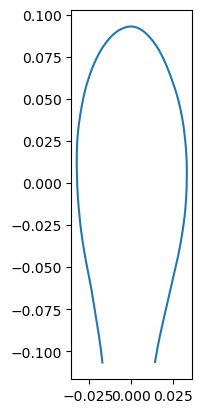

In [6]:
landmark_num = res # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(lf_arr, landmark_num, dim_num)

pca = PCA(n_components=2) # perform PCA to align along longest axis
pca = pca.fit_transform(mean_shape)

rot_x, rot_y = rotate_points(pca[:,0], pca[:,1], 180) # rotate mean leaf upwards
rot_mean = np.column_stack((rot_x, rot_y))

plt.plot(rot_mean[:,0], rot_mean[:,1]) # plot mean leaf
plt.gca().set_aspect("equal")

Text(0.5, 1.0, 'overall mean leaf')

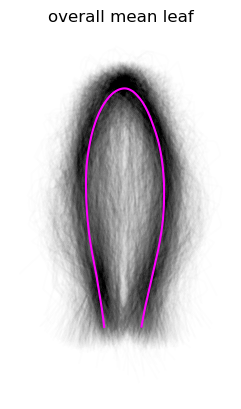

In [7]:
################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(lf_arr)) 

for i in range(len(lf_arr)):
    s1, s2, distance = procrustes(rot_mean, lf_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array

for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.007)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean leaf")


# Morphospace

In [8]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = res*2 # PC number = res*2
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 33.9%, 33.9%
PC2: 27.8%, 61.7%
PC3: 12.4%, 74.1%
PC4: 7.0%, 81.1%
PC5: 4.8%, 85.9%
PC6: 2.5%, 88.4%
PC7: 2.1%, 90.5%
PC8: 1.5%, 92.0%
PC9: 1.0%, 93.0%
PC10: 0.8%, 93.7%
PC11: 0.7%, 94.4%
PC12: 0.5%, 94.9%
PC13: 0.4%, 95.4%
PC14: 0.4%, 95.8%
PC15: 0.4%, 96.2%
PC16: 0.3%, 96.5%
PC17: 0.3%, 96.8%
PC18: 0.3%, 97.1%
PC19: 0.3%, 97.4%
PC20: 0.2%, 97.6%
PC21: 0.2%, 97.8%
PC22: 0.2%, 98.0%
PC23: 0.2%, 98.2%
PC24: 0.2%, 98.4%
PC25: 0.2%, 98.5%
PC26: 0.1%, 98.7%
PC27: 0.1%, 98.8%
PC28: 0.1%, 98.9%
PC29: 0.1%, 99.0%
PC30: 0.1%, 99.1%
PC31: 0.1%, 99.2%
PC32: 0.1%, 99.2%
PC33: 0.1%, 99.3%
PC34: 0.1%, 99.4%
PC35: 0.1%, 99.4%
PC36: 0.0%, 99.5%
PC37: 0.0%, 99.5%
PC38: 0.0%, 99.5%
PC39: 0.0%, 99.6%
PC40: 0.0%, 99.6%
PC41: 0.0%, 99.6%
PC42: 0.0%, 99.7%
PC43: 0.0%, 99.7%
PC44: 0.0%, 99.7%
PC45: 0.0%, 99.7%
PC46: 0.0%, 99.8%
PC47: 0.0%, 99.8%
PC48: 0.0%, 99.8%
PC49: 0.0%, 99.8%
PC50: 0.0%, 99.8%
PC51: 0.0%, 99.8%
PC52: 0.0%, 99.8%
PC53: 0.0%, 99.9%
PC54: 0.0%, 99.9%
PC55: 0.0%, 99.9

In [9]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 10 # select number for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# create dataframe for plotting
mdata = pd.DataFrame({
    "page":pg_num_list,
    "plant":pl_num_list,
    "ID":pl_ID_list,
    "author_ID":author_ID
})

# add the PCs to the dataframe
for i in range(PC_NUMBER):
    mdata["PC"+str(i+1)] = PCs[:,i]

PC: var, overall 
PC1: 33.9%, 33.9%
PC2: 27.8%, 61.7%
PC3: 12.4%, 74.1%
PC4: 7.0%, 81.1%
PC5: 4.8%, 85.9%
PC6: 2.5%, 88.4%
PC7: 2.1%, 90.5%
PC8: 1.5%, 92.0%
PC9: 1.0%, 93.0%
PC10: 0.8%, 93.7%


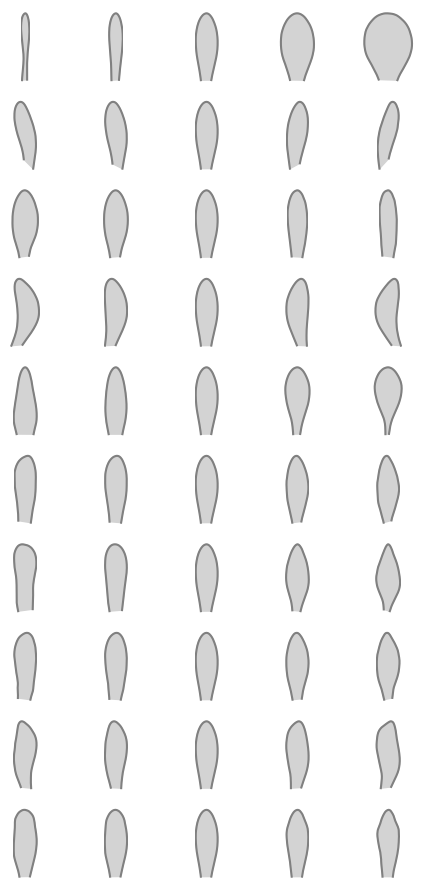

In [10]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
stdev_list = [] # list to store standard deviations for each PC
for i in range(PC_NUMBER):
    stdev_list.append(mdata["PC"+str(i+1)].std())

# create an array of PC values to reconstruct
# for each PC_NUMBER
# calculate PC_NUMBER values
# for each standard deviation value in sdev_vals
sdev_vals = [-2,-1,0,1,2] # standard deviation values to calculate
PC_vals = np.zeros((PC_NUMBER,PC_NUMBER,5)) # an array of PC values to evaluate
for i in range(PC_NUMBER): # for the ith PC
    for j in range(len(sdev_vals)): # for each standard deviation position
        PC_vals[i,i,j] = sdev_vals[j]*stdev_list[i]

# Plot
plt.figure(figsize=(5,9))

counter = 1

for i in range(np.shape(PC_vals)[0]):
    for j in range(len(sdev_vals)):
    
        # create inverse leaf
        inv_leaf = pca.inverse_transform(np.array(PC_vals[i,:,j]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot inverse leaf
        plt.subplot(PC_NUMBER,len(sdev_vals),counter)
        plt.fill(inv_x, inv_y, c="lightgray")
        plt.plot(inv_x, inv_y, c="gray")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        
        counter += 1

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Procrustean morphospace\n69 plants, 2031 leaves')

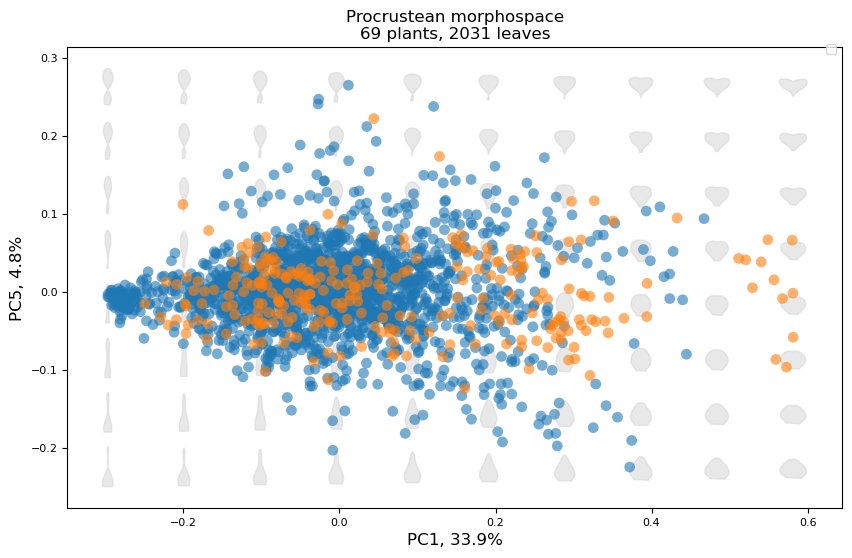

In [11]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPCa = 10 # set number of PCa intervals
numPCb = 8 # set number of PCb intervals
hue = "author_ID" # select the factor to color by
s = 0.2 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 60 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace\n" + str(len(mdata["ID"].unique())) + " plants, " + str(len(PCs)) + " leaves" # set title

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 4 # index position of second PC
##########################

PCa_vals = np.linspace( np.min(PCs[:,PCa]), np.max(PCs[:,PCa]), numPCa ) # create PC intervals
PCb_vals = np.linspace( np.min(PCs[:,PCb]), np.max(PCs[:,PCb]), numPCb )

plt.figure(figsize=(plot_length, plot_width))

for i in PCa_vals: # for each PCa interval
    for j in PCb_vals: # for each PCb interval
        
        pca_val = i # select the current PCa val
        pcb_val = j # select the current PCb val

        eigen_arr = np.zeros((PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
        eigen_arr[PCa] = pca_val # set the PCa value
        eigen_arr[PCb] = pcb_val # set the PCb value
        
        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(eigen_arr)
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pca_val, inv_y*s+pcb_val, c=lf_col, alpha=lf_alpha)

# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC"+str(PCa+1), y="PC"+str(PCb+1), hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=False)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC"+str(PCa+1)+", " + str(round(pca.explained_variance_ratio_[PCa]*100,1)) + "%"
ylab = "PC"+str(PCb+1)+", " + str(round(pca.explained_variance_ratio_[PCb]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

# Model PC trajectories

### Lines across 2D morphospace

Use PCa and PCb axes above in PC_NUMBER dimensional PC space. Note: PCs may not be successive

In [26]:
##############################################################################
##############################################################################
##############################################################################

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 4 # index position of second PC
##########################

### Set grid density
##########################
grid_density = 0.01 # density to sample points on leaves
##########################

### Set the number of leaves in the series
### random sample between min and max values
##########################
low_lf_num = 4 # inclusive
high_lf_num = 21 # not including
n = np.random.randint(low_lf_num, high_lf_num)
##########################

### Calculate relative leaf lengths along the leaf series
##########################
# set height of first leaf relative to one
low_juv_len = 0.1 # inclusive
high_juv_len = 1 # not including
juv_len = np.random.uniform(low_juv_len, high_juv_len)

# set node position of max height of 1 (0 to 1)
node_max = np.random.uniform(0, 1)

# set height of last leaf relative to one
low_adult_len = 0.1 # inclusive
high_adult_len = 1 # not including
adult_len = np.random.uniform(low_adult_len, high_adult_len)

# find relative lengths for each leaf (to 1)
coeffs = np.polyfit(x=[0,node_max,1], y=[juv_len,1,adult_len], deg=2) # calculate coefficients
func = np.poly1d(coeffs) # calculate 2D polynomial function
lf_lens = func(np.linspace(0,1,n)) # calculate leaf lengths relative to 1
##########################

### Calculate relative leaf curvature (interior)
##########################
leaf_curve = 0.8 # scaling of leaf curvature (the interior of the leaf)
leaf_curl = 0.8 # scaling of leaf curl (across length of leaf)
##########################

### Calculate leaf curl (length)
##########################
# set maximum displacement at leaf tip (y value)
max_down_curl = -1
max_up_curl = 1
leaf_tip = np.random.uniform(max_down_curl,max_up_curl)

# set middle of leaf curl (y value)
leaf_mid = np.random.uniform(0,leaf_tip)
##########################

### Calculate elevation angles
##########################
ang_min_limit = 10 # max possible min angle
ang_max_limit = 90 # max possible angle
angle_min = np.random.uniform(0,ang_min_limit) # get the minimum angle
angle_max = np.random.uniform(angle_min,ang_max_limit) # get the maximum angle
angs = np.linspace(angle_min, angle_max, n)
##########################

### Phyllotaxy angle
##########################
phyllo_ang = 137.5077640500378546463487

##############################################################################
##############################################################################
##############################################################################

#####
# FIND LEAF SERIES LINE IN MORPHOSPACE
#####

# index position 1, 0 is PCa
# index position 1, 1 is PCb

# retrieve just the desired two PCs
just_PCs = PCs[:,[PCa,PCb]]

# create the convex hull
hull = ConvexHull(just_PCs)

# retreieve hull points
hull_points = just_PCs[hull.vertices]

# find two random points in 2D convex hull
# these are the terminal points of the line
term_pts = dist_in_hull(hull_points,2)

start_point = term_pts[0]
end_point = term_pts[1]

#####
# SPECIFY NUMBER OF LEAVES IN LEAF SERIES
#####

# Create an array of evenly spaced values from 0 to 1
t_values = np.linspace(0, 1, n)

# Calculate the points using linear interpolation
points = np.array([start_point + t * (end_point - start_point) for t in t_values])

# calculate eigen leaves
eigen_arr = np.zeros((len(points),PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
eigen_arr[:,PCa] = points[:,0] # set the PCa values
eigen_arr[:,PCb] = points[:,1] # set the PCb values

# calculate the inverse eigenleaf
inv_leaf = pca.inverse_transform(eigen_arr)
inv_x = inv_leaf[:,0::2] # select just inverse x vals
inv_y = inv_leaf[:,1::2] # select just inverse y vals

# create an array of the leaf series
leaf_lines = np.stack((inv_x, inv_y), axis=1)
leaf_lines = np.swapaxes(leaf_lines, 1,2)

#####
# CHECK FOR SELF-INTERSECTION
#####

self_intersect = 0 # assume no self intersect
for i in range(len(leaf_lines)):
    if is_self_intersecting(leaf_lines[i]):
        self_intersect+=1
    else:
        continue
if self_intersect==0:
    print("Leaf series is OK")
elif self_intersect!=0:
    print("SELF-INTERSECTION!")

#####
# TRANSLATE LEAF BASE TO ORIGIN
#####

trans_lfs = np.zeros(np.shape(leaf_lines))

for i in range(len(leaf_lines)):
    start_pt = leaf_lines[i,0,:] # leaf start
    end_pt = leaf_lines[i,-1,:] # leaf end
    base_pt = np.mean((start_pt, end_pt), axis=0) # base point of leaf
    trans_lf = leaf_lines[i,:,:] - base_pt # translated lf
    trans_lfs[i,:,:] = trans_lf # save translated lf

#####
# SCALE LEAF LENGTHS ACROSS LEAF SERIES
#####

scaled_lfs = np.zeros(np.shape(trans_lfs))

for i in range(n): # for each leaf in the series
    scale_len_lf = trans_lfs[i,:,:]/np.max(trans_lfs[i,:,1]) # scale leaf len to 1
    scale_len_lf = scale_len_lf*lf_lens[i] # scale leaf to desired length
    scaled_lfs[i,:,:] = scale_len_lf # save scaled length leaf

#####
# CALCULATE LEAF SURFACE VALUES AND ELEVATION
#####

pts_3D = [] # list of x, y, z 
tris_3D = [] # list of triangles

for i in range(len(scaled_lfs)): # for each leaf

    print(i)

    curr_lf = scaled_lfs[i] # get current leaf
    
    grid_pts = grid_points_in_polygon(curr_lf, grid_density) # calculate grid points
    
    # Delauney triangulation
    # tris = indices of individual triangles in points
    pts, tris = delaunay_triangulation_within_polygon(grid_pts, Polygon(curr_lf)) # calculate Delauney triangulation
    
    # get distances of each grid point to polygon boundary
    dists=[]
    for j in range(len(pts)):
        dists.append(shortest_distance_to_polygon((pts[j,0],pts[j,1]),curr_lf))
    scaled_lf_curve = np.array(dists)*leaf_curve # get scaled leaf curvature
    
    # calculate leaf curl from distance to base
    coeffs = np.polyfit(x=[0,0.5,1], y=[0,leaf_mid,leaf_tip], deg=2) # calculate coefficients
    func = np.poly1d(coeffs) # calculate 2D polynomial function
    
    lf_curl_vals = func(pts[:,1])*leaf_curl # calculate leaf lengths relative to 1
    
    lf_surf_vals = scaled_lf_curve+lf_curl_vals # calculate overall curvature

    lf_surf_lf = np.column_stack((pts, lf_surf_vals)) # combine x, y, and z vals

    # translate the z axis to the origin
    lf_surf_lf[:,2] = lf_surf_lf[:,2] - np.mean(lf_surf_lf[:,2][lf_surf_lf[:,1]==np.min(lf_surf_lf[:,1])]  )

    # rotate leaf
    rot_x, rot_y = rotate_points(lf_surf_lf[:,0],lf_surf_lf[:,1], phyllo_ang*i)
    lf_surf_lf[:,0:2] = np.column_stack((rot_x, rot_y))

    # Warp Dlauney triangulation into 3D
    # get surface values of leaf
    z_raw = lf_surf_lf[:,2]

    # get the x and y coordinate values
    vertices_2d = lf_surf_lf[:,0:2]
    
    # Area-preserving adjustment
    z_warped = preserve_area(vertices_2d, tris, z_raw)
    
    # Now vertices_3d = [x, y, z_warped]
    vertices_3d = np.hstack([vertices_2d, z_warped[:, np.newaxis]])

    # Elevate the leaves
    # elevate the points
    elv_pts = lift_points_radially(vertices_3d, angs[i])
    
    pts_3D.append(elv_pts) # append points to list
    tris_3D.append(tris) # append triangle 


Leaf series is OK
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


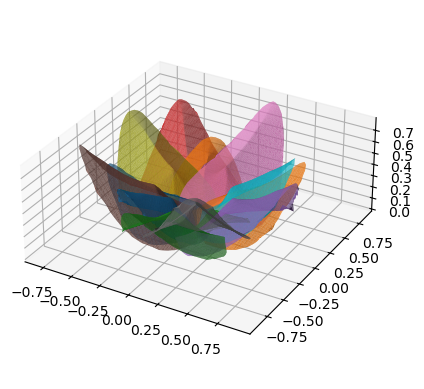

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', azim=-60, elev=30)

for i in range(len(pts_3D)):
    ax.plot_trisurf(pts_3D[i][:, 0], pts_3D[i][:, 1], pts_3D[i][:, 2], triangles=tris_3D[i])
    plt.gca().set_aspect("equal")

## Concatenate the leaf mesh objects

In [28]:
mesh = trimesh.Trimesh(vertices=pts_3D[0], faces=tris_3D[0])

for i in range(1, len(pts_3D)):
    new_mesh = trimesh.Trimesh(vertices=pts_3D[i], faces=tris_3D[i])
    mesh = trimesh.util.concatenate(mesh, new_mesh)

mesh.show()